In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import time

import numpy as np
from abcpy.core import *
from abcpy.distributions import *
from distributed import Client
from dask.dot import dot_graph
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
client = Client()

In [3]:
def normal_simu(n, mu, prng=None, latents=None):
    if latents is None:
        if prng is None:
            prng = np.random.RandomState()
        latents = prng.randn(n)
    u = mu + latents
    y = u
    return y

def mean(y):
    mu = np.mean(y, axis=1, keepdims=True)
    return mu

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d


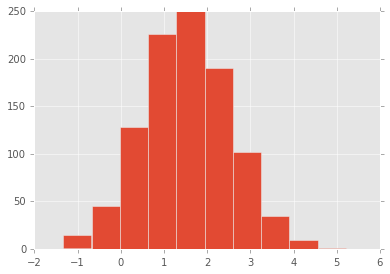

In [4]:
n = 1000
mu = 1.6

# Set up observed data y
latents = np.random.randn(n)
y = normal_simu(n, mu, latents=latents)

# Plot
plt.hist(y);

In [5]:
# Set up the simulator
simulator = partial(normal_simu, n)

# Specify the graphical model
mu = Prior('mu', 'uniform', 0, 4)
Y = Simulator('normal_simu', simulator, mu, observed=y)
S1 = Summary('S1', mean, Y)
d = Discrepancy('d', distance, S1)

# Specify the number of simulations
N = 1000000

# Time and run parallel
s = time.time()
dists = d.generate(N, batch_size=10000).compute()

print("Elapsed time %d sec" % (time.time() - s))

# Take the parameters
mu_sample = mu.generate(N).compute()

Elapsed time 5 sec


In [6]:
# Set threshold and reject to get posteriors
eps = 0.01
accepts = dists < eps
mu_post = mu_sample[accepts]
print("Number of accepted samples %d" % sum(accepts))

Number of accepted samples 5015


Posterior for $\mu$


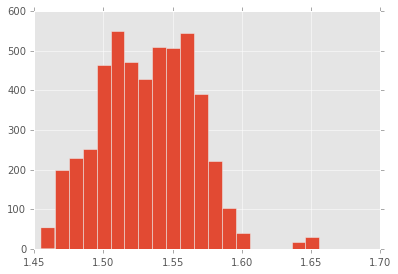

In [7]:
if len(mu_post) > 0:
    print("Posterior for $\mu$")
    plt.hist(mu_post, bins=20)
else:
    print("No accepted samples")